In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_glm2 import Sub_Clust_Cos_GLM
from models.clust_gru import Clust_GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
rest_idx = np.delete(np.arange(2000), e_idx)
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
rest_idx = torch.from_numpy(rest_idx)

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 1
E_no = 2000
I_no = 200
#E_no = 299
#I_no = 8
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
#model = Clust_GRU(sub_no, E_no, I_no, H_no, device)

syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw"):
        syn_params.append(params)
    elif (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

# GLM
optimizer = torch.optim.Adam(rest_params, lr = 0.005/(1.03**100))
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005)
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.03)
syn_milestones = np.arange(increment-1, increment*100, increment)
syn_scheduler = torch.optim.lr_scheduler.MultiStepLR(syn_optimizer, milestones=syn_milestones, gamma=1)

# GRU
#optimizer = torch.optim.Adam(rest_params, lr = 0.005)
#syn_optimizer = torch.optim.Adam(syn_params, lr = 0.001)
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)
#syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=increment, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

print(sum(p.numel() for p in syn_params if p.requires_grad))
print(sum(p.numel() for p in rest_params if p.requires_grad))
print(milestones.shape)

13701
11000
2701
(100,)


In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

score_list = []
temp_list = np.logspace(0,-3,100)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    syn_optimizer.zero_grad()
           
    with torch.no_grad():
        model.C_syn_e_raw.copy_(model.C_syn_e_raw - torch.mean(model.C_syn_e_raw, 0).reshape(1,-1))
        model.C_syn_i_raw.copy_(model.C_syn_i_raw - torch.mean(model.C_syn_i_raw, 0).reshape(1,-1))
    
    if (temp_count < 99) & (i%increment == increment-1):
        temp_count += 1
    temp = torch.tensor([temp_list[temp_count]]).to(device).float()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    g_e = torch.zeros_like(model.C_syn_e_raw)
    g_i = torch.zeros_like(model.C_syn_i_raw)
    
    V_pred, _, C_syn_e, C_syn_i  = model(batch_E_neural, batch_I_neural, temp, False, g_e, g_i)
    #V_pred, _, C_syn_e, C_syn_i  = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx], temp)
    
    #loss = torch.mean((V_pred - batch_V[:,5000:35000])**2)
    loss = torch.mean((V_pred - batch_V[:,:])**2)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    syn_optimizer.step()
    syn_scheduler.step()
    grad_size = torch.mean(torch.abs(model.C_syn_e_raw.grad)).item()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), 0.0001, True, g_e, g_i)
        #test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx], 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        #test_score = explained_variance_score(V_test[5000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        #test_mse = torch.mean((V_test[5000:35000]-test_V_pred)**2).item()
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        train_score = explained_variance_score(batch_V[0].cpu().detach().numpy(), V_pred[0].cpu().detach().numpy())
        score_list.append(test_score)
        
        C_syn_idx = torch.argmax(test_C_syn_e[:,880:1120], 0).float()
        #C_syn_idx = torch.argmax(test_C_syn_e[:,29:269], 0).float()
        
        mode1, mode1_idx = torch.mode(C_syn_idx[:60])
        mode2, mode2_idx = torch.mode(C_syn_idx[60:120])
        mode3, mode3_idx = torch.mode(C_syn_idx[120:180])
        mode4, mode4_idx = torch.mode(C_syn_idx[180:240])
        mode1_no = torch.numel(torch.where(C_syn_idx[:60] == mode1)[0])
        mode2_no = torch.numel(torch.where(C_syn_idx[60:120] == mode2)[0])
        mode3_no = torch.numel(torch.where(C_syn_idx[120:180] == mode3)[0])
        mode4_no = torch.numel(torch.where(C_syn_idx[180:240] == mode4)[0])
        
        C_syn_std = torch.std(model.C_syn_e_raw).item()
                        
        print(i, np.round(test_score,6), np.round(train_score,6), np.round(C_syn_std,6))
        print(mode1.item(), mode2.item(), mode3.item(), mode4.item())
        print(mode1_no, mode2_no, mode3_no, mode4_no)
        print("------------------------")

  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.489081 -0.436194 0.396257
4.0 0.0 0.0 2.0
19 15 21 15
------------------------
49 -0.084886 -0.016453 0.39314
4.0 0.0 0.0 2.0
19 15 21 15
------------------------
99 -0.021569 0.007297 0.389412
4.0 0.0 0.0 2.0
18 16 20 17
------------------------
149 0.03287 0.116843 0.385662
4.0 0.0 0.0 2.0
18 16 20 20
------------------------
199 0.097543 0.154794 0.382384
2.0 0.0 0.0 2.0
15 15 19 22
------------------------
249 0.123078 0.090785 0.379956
3.0 0.0 2.0 2.0
21 16 20 24
------------------------
299 0.114436 0.156923 0.379186
3.0 0.0 2.0 2.0
22 17 22 24
------------------------
349 0.178316 0.305306 0.379369
3.0 3.0 0.0 2.0
24 20 19 20
------------------------
399 0.197154 0.243264 0.379888
3.0 3.0 2.0 2.0
25 25 20 24
------------------------
449 0.212891 0.211427 0.380541
3.0 3.0 0.0 2.0
25 28 17 23
------------------------
499 0.210341 0.233517 0.381855
2.0 3.0 0.0 2.0
25 30 16 27
------------------------
549 0.215547 0.260387 0.383599
3.0 3.0 0.0 2.0
29 30 17 27
------------------

4899 0.40207 0.447232 1.106192
2.0 3.0 1.0 2.0
58 60 47 59
------------------------
4949 0.397381 0.370662 1.11455
2.0 3.0 1.0 2.0
60 60 46 60
------------------------
4999 0.39581 0.525982 1.123191
2.0 3.0 1.0 2.0
59 60 48 58
------------------------
5049 0.414883 0.454303 1.132045
2.0 3.0 1.0 2.0
60 60 47 58
------------------------
5099 0.330574 0.467167 1.140409
2.0 3.0 1.0 2.0
59 60 43 60
------------------------
5149 0.422508 0.497558 1.148489
2.0 3.0 1.0 2.0
60 60 41 60
------------------------
5199 0.426913 0.451822 1.157041
2.0 3.0 1.0 2.0
60 60 44 60
------------------------
5249 0.413641 0.410659 1.165403
2.0 3.0 1.0 2.0
60 60 45 59
------------------------
5299 0.417021 0.369796 1.173461
2.0 3.0 1.0 2.0
60 60 47 59
------------------------
5349 0.417823 0.465089 1.181335
2.0 3.0 1.0 2.0
60 60 44 60
------------------------
5399 0.410848 0.438506 1.189811
2.0 3.0 1.0 2.0
60 60 42 60
------------------------
5449 0.41191 0.441433 1.199472
2.0 3.0 1.0 2.0
60 60 42 60
---------

9749 0.44259 0.400396 1.769305
2.0 3.0 1.0 2.0
59 60 49 58
------------------------
9799 0.402268 0.4349 1.774729
2.0 3.0 1.0 2.0
58 60 47 57
------------------------
9849 0.405457 0.457618 1.781053
2.0 3.0 1.0 2.0
56 60 52 58
------------------------
9899 0.418934 0.448818 1.785798
2.0 3.0 1.0 2.0
59 60 46 60
------------------------
9949 0.437938 0.54692 1.792375
2.0 3.0 1.0 2.0
58 60 45 58
------------------------
9999 0.436894 0.428449 1.798451
2.0 3.0 1.0 2.0
60 60 53 60
------------------------
10049 0.424053 0.503304 1.803967
2.0 3.0 1.0 2.0
57 60 51 59
------------------------
10099 0.423205 0.437442 1.809499
2.0 3.0 1.0 2.0
59 60 51 60
------------------------
10149 0.423398 0.43552 1.816062
2.0 3.0 1.0 2.0
60 60 51 57
------------------------
10199 0.454981 0.493296 1.821399
2.0 3.0 1.0 2.0
60 60 51 58
------------------------
10249 0.422744 0.4906 1.827035
2.0 3.0 1.0 2.0
60 60 53 60
------------------------
10299 0.435945 0.414609 1.832672
2.0 3.0 1.0 2.0
60 60 44 58
------

14549 0.459681 0.553775 2.242635
2.0 3.0 1.0 2.0
55 60 52 58
------------------------
14599 0.447086 0.493873 2.246948
2.0 3.0 1.0 2.0
57 60 40 58
------------------------
14649 0.450173 0.492064 2.251327
2.0 3.0 1.0 2.0
60 59 51 59
------------------------
14699 0.453919 0.458648 2.255353
2.0 3.0 1.0 2.0
58 60 51 60
------------------------
14749 0.45576 0.445894 2.259624
2.0 3.0 1.0 2.0
57 60 48 58
------------------------
14799 0.459851 0.489024 2.263818
2.0 3.0 1.0 2.0
56 60 47 56
------------------------
14849 0.446223 0.418661 2.268396
2.0 3.0 1.0 2.0
60 60 48 55
------------------------
14899 0.449857 0.487996 2.272639
2.0 3.0 1.0 2.0
59 59 47 59
------------------------
14949 0.452346 0.440941 2.2768
2.0 3.0 1.0 2.0
57 60 48 57
------------------------
14999 0.440583 0.422544 2.281324
2.0 3.0 1.0 2.0
58 60 47 55
------------------------
15049 0.458167 0.515826 2.285505
2.0 3.0 1.0 2.0
59 59 51 57
------------------------
15099 0.450051 0.486546 2.289711
2.0 3.0 1.0 2.0
57 60 44

19349 0.460095 0.485402 2.595467
2.0 3.0 1.0 2.0
58 58 52 56
------------------------
19399 0.466023 0.435359 2.598266
2.0 3.0 1.0 2.0
59 59 50 57
------------------------
19449 0.466285 0.553462 2.601184
2.0 3.0 1.0 2.0
57 59 46 57
------------------------
19499 0.428988 0.475899 2.604042
2.0 3.0 1.0 2.0
57 58 47 56
------------------------
19549 0.453089 0.412359 2.607382
2.0 3.0 1.0 2.0
55 57 47 53
------------------------
19599 0.452777 0.496721 2.6104
2.0 3.0 1.0 2.0
57 60 51 56
------------------------


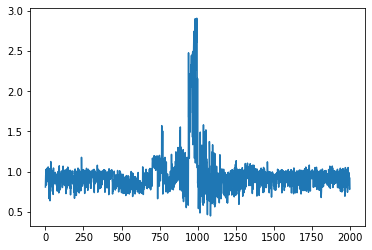

In [7]:
plt.plot(torch.exp(model.E_scale).cpu().detach().numpy())

-9.108987808227539 11.997953414916992
-10.686781883239746 14.478303909301758
-10.414304733276367 9.088255882263184
-9.741973876953125 9.597567558288574


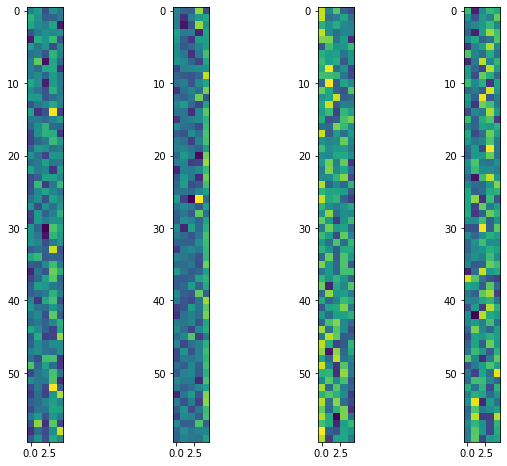

In [8]:
fig, axs = plt.subplots(ncols=4, figsize = (10,8))
start_idx = 880

for i in range(4):
    axs[i].imshow(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i].cpu().detach().numpy().T)
    print(torch.min(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i]).item(),
          torch.max(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i]).item())

In [10]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(test_C_syn_e[:,e])

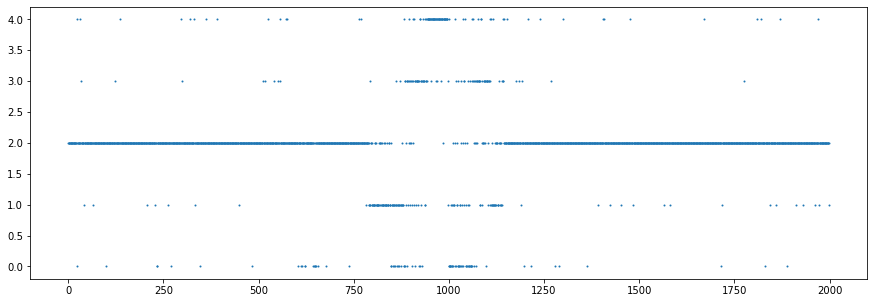

In [11]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

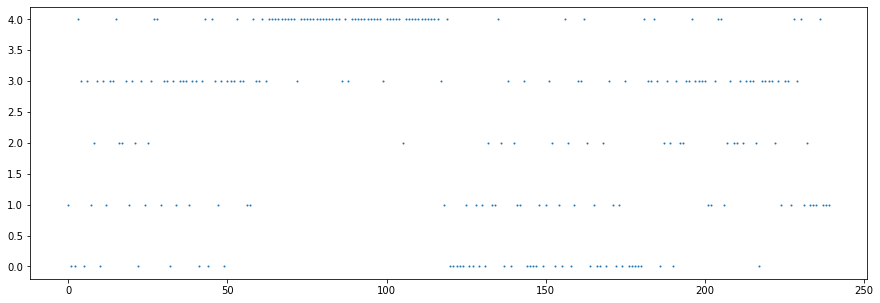

In [12]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

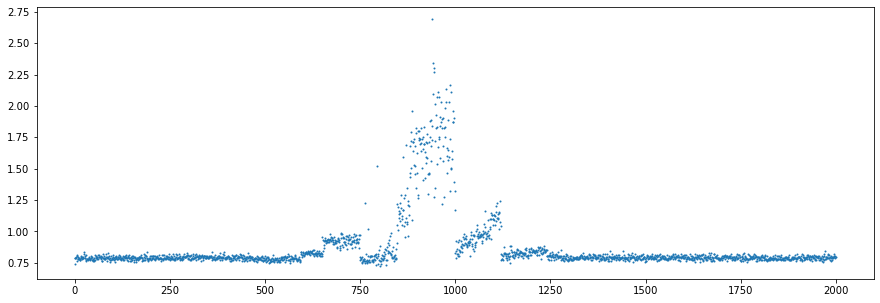

In [12]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [8]:
E_scale = model.E_scale.cpu().detach().numpy()
C_syn_e_raw = model.C_syn_e_raw.cpu().detach().numpy()

In [9]:
#np.savez("/media/hdd01/sklee/CA1_clust4-60/clust/pretrain_glm_s5_h2.npz",
        E_scale=E_scale,
        C_syn_e_raw=C_syn_e_raw)